# Class Imbalance Using ML Insights

##  Overview

Oracle ML Insights helps improve your machine learning models by detecting potential bias and fairness issues which surface during different stages of ML lifecycle (data collection, model training, and monitoring of deployed models).

# Install ML Observability Insights Library SDK

- Prerequisites
- Linux/Mac (Intel CPU)
- Python 3.8 and 3.9 only


- Installation
- ML Insights is made available as a Python package (via Artifactory) which can be installed using pip install as shown below. Depending on the execution engine on which to do the run, one can use scoped package. For eg: if we want to run on dask, use oracle-ml-insights[dask], for spark use oracle-ml-insights[spark], for native use oracle-ml-insights. One can install all the dependencies as use oracle-ml-insights[all]

!pip install oracle-ml-insights

Refer : [Installation and Setup](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/tutorials/install.html)

In [31]:
!python3 -m pip install oracle-ml-insights


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

## Data Inspection


We will be working with Census Adult income dataset for a Binary Classification model which predicts whether annual income > $50k. Dataset contains 14 features concerning demographic characteristics. Some features relevant for our demo have been highlighted below:

Marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

Gender: Male, Female

Ethnic group: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

In [33]:
def load_data():
    training_data = pd.read_csv(
    "input_data/census_income_dataset.csv", sep=r"\s*,\s*", engine="python", na_values="?"
    )
    return training_data

In [34]:
df = load_data()

In [35]:
df.head(10)

,ID,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country,Target
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


For this demo, we will consider two features from our dataset to be protected attributes. First we will inspect their distributions and then compute Class Imbalance metric for each of the protected attribute

### Gender Protected Attribute
Let's take a look specifically at the Gender feature of a census respondent.

We will plot the frequency distribution to see the way the genders are represented
We will plot the frequency distribution by considering the model prediction for a positive outcome.

In [36]:
def plot_feature(df, title, chart_type='bar'):
    df.value_counts().sort_values().plot(kind=chart_type, title=title, rot=90)

def plot_pie(labels, sizes):
    fig1, ax1 = plt.subplots()
    plt.figure(figsize=(300,100))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=0)
    ax1.axis('equal')

    plt.show()

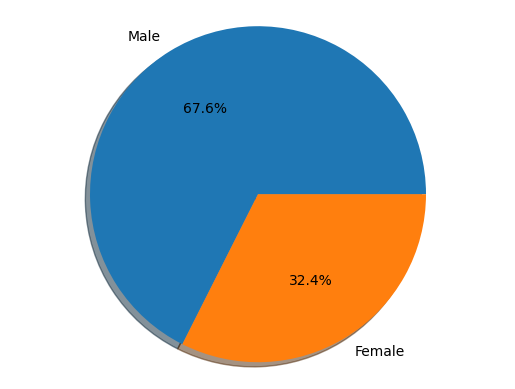

<Figure size 30000x10000 with 0 Axes>

In [37]:
# plot ferquency distribution for Gender feature
# plot_feature(df=df['Gender'], title="Counts of Gender")
plot_pie(labels=df['Gender'].unique(), sizes=df['Gender'].value_counts())

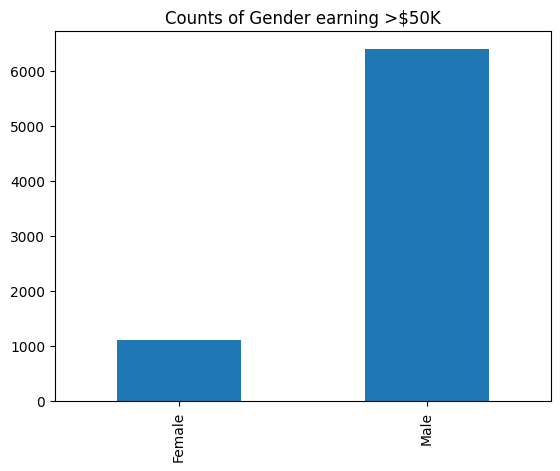

In [38]:
# plot frequency distribution for Gender feature when model has predicted >=50k annual income
plot_feature(df=df["Gender"].where(df["Target"] == ">50K"), title="Counts of Gender earning >$50K")

### Ethnic Group Protected Attribute
Now let's take a look specifically at the Ethnic Group feature of a census respondent.

We will plot the frequency distribution to see the way the ethnic groups are represented
We will plot the frequency distribution by considering the model prediction for a positive outcome.

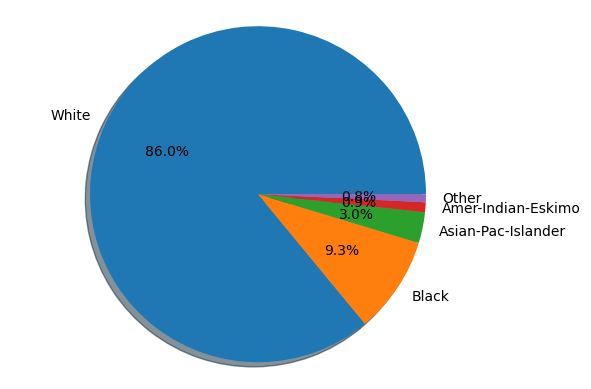

<Figure size 30000x10000 with 0 Axes>

In [39]:
# plot ferquency distribution for Gender feature
# plot_feature(df=df['Ethnic group'], title="Frequency Distribution of Ethnic Groups")
plot_pie(labels=df['Ethnic group'].unique(), sizes=df['Ethnic group'].value_counts())

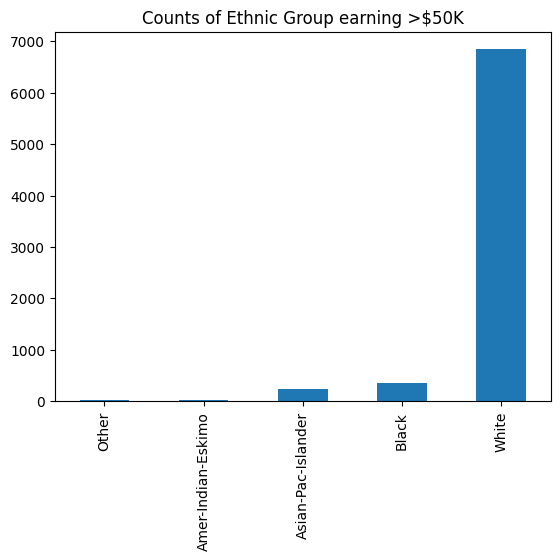

In [40]:
# plot frequency distribution for Ethnic Group feature when model has predicted >=50k annual income
plot_feature(df=df["Ethnic group"].where(df["Target"] == ">50K"), title="Counts of Ethnic Group earning >$50K")

In [41]:
df['Ethnic group'].value_counts()

White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: Ethnic group, dtype: int64

## Using ML Insights to compute Class Imbalance

In [42]:
from mlm_insights.builder.builder_component import MetricDetail, EngineDetail
from mlm_insights.builder.insights_builder import InsightsBuilder
from mlm_insights.constants.types import FeatureType, DataType, VariableType
from mlm_insights.core.metrics.bias_and_fairness.class_imbalance import ClassImbalance,\
    CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD,\
    CLASS_IMBALANCE_VALUE, \
    CONFIG_KEY_FOR_DROP_NAN_VALUES
from mlm_insights.core.metrics.metric_metadata import MetricMetadata



### Using Builder

### Configuring input Schema

In [43]:
input_schema = {
    'Ethnic group': FeatureType(data_type=DataType.STRING,
                                variable_type=VariableType.NOMINAL),
    'Gender': FeatureType(data_type=DataType.STRING,
                          variable_type=VariableType.NOMINAL),
    'Target' : FeatureType(data_type=DataType.STRING,
                           variable_type=VariableType.NOMINAL)

}

#### Computing Class Imbalance for Binary facet data

In [44]:
metric_detail_for_gender = []

metric_detail_for_female = \
MetricMetadata(klass=ClassImbalance, config={CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD: ['Female']})

metric_detail_for_male = \
MetricMetadata(klass=ClassImbalance, config={CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD: ['Male']})

metric_detail_for_gender.append(metric_detail_for_female)
metric_detail_for_gender.append(metric_detail_for_male)

metric_details = MetricDetail(univariate_metric={"Gender": metric_detail_for_gender}, dataset_metrics=[])

#### Computing Class Imbalance for Multi facet data

In [45]:
metric_detail_for_ethnic_group =[]
for key in df['Ethnic group'].value_counts().keys():
    mat_detail = MetricMetadata(klass=ClassImbalance, config={CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD: [key]})
    metric_detail_for_ethnic_group.append(mat_detail)

metric_details.univariate_metric['Ethnic group'] = metric_detail_for_ethnic_group

metric_detail_with_fewers_keys= MetricMetadata(klass=ClassImbalance,
                                               config={CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD: ['Black','Other']})
metric_detail_for_ethnic_group.append(metric_detail_with_fewers_keys)

### Configuring builder

In [46]:
df.head()

,ID,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Gender,Capital Gain,Capital Loss,Hours per week,Country,Target
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [47]:
runner = InsightsBuilder(). \
    with_input_schema(input_schema). \
    with_data_frame(data_frame=df). \
    with_metrics(metrics=metric_details). \
    with_engine(engine=EngineDetail(engine_name='native')). \
    build()

In [48]:
run_result = runner.run()
profile = run_result.profile

### Querying data profile

In [49]:
profile_json = profile.get_feature('Gender').get_metric(
    metric_detail_for_female
).get_result()

In [50]:
profile_json[CLASS_IMBALANCE_VALUE]

-0.3513692725946555

In [51]:
profile_json = profile.get_feature('Gender').get_metric(
    metric_detail_for_male
).get_result()

In [52]:
profile_json[CLASS_IMBALANCE_VALUE]

0.3513692725946555

In [53]:
metric_query_result ={}
metric_query_result['Ethnic group'] = []
metric_query_result[CLASS_IMBALANCE_VALUE] = []
for metric_detail in metric_detail_for_ethnic_group:
    profile_json = profile.get_feature('Ethnic group').get_metric(
        metric_detail
    ).get_result()
    metric_query_result['Ethnic group'].append(profile_json[CONFIG_KEY_FOR_FEATURE_VALUES_OR_THRESHOLD])
    metric_query_result[CLASS_IMBALANCE_VALUE].append(profile_json[CLASS_IMBALANCE_VALUE])

In [54]:
output_race_df = pd.DataFrame(metric_query_result)
output_race_df.head(10)

,Ethnic group,class_imbalance_value
0,[White],0.719581
1,[Black],-0.813209
2,[Asian-Pac-Islander],-0.940654
3,[Amer-Indian-Eskimo],-0.981036
4,[Other],-0.984683
5,"[Black, Other]",-0.797891


### Monitor config for equivalent Builder Config
This example notebook showcases how to use Insights builder to compute class imbalance for binary or multi-facet data.  Sample monitor config JSON (to be used via Insights config reader) and sample data are available under `monitor_configs/sample_monitor_config_class_imbalance.json` and `input_data/iris-dataset` respectively.